## Astrostatistics Homework

In this homework, we study a bivariate Gaussian distribution with mean  
$$
\mu = \begin{pmatrix} 4 \\ 2 \end{pmatrix}
$$  
and covariance matrix  
$$
\Sigma = \begin{pmatrix} 1.44 & -0.702 \\ -0.702 & 0.81 \end{pmatrix},
$$  
which we assume to be the posterior distribution of two parameters, \( X_1 \) and \( X_2 \).

First, we plot the contours of the posterior and indicate the 95% credible region. To achieve this, we define the necessary quantities such as $ \mu $ and $ \Sigma $, then create a $1000 \times 1000$ grid over the parameter space with $ X_1 \in [0,\, 8] $ and $ X_2 \in [-1,\, 5] $, ensuring that the important contours of the posterior fall well within the plotted range.

Next, we stack the coordinates and evaluate the bivariate Gaussian PDF across the grid using `scipy.stats.multivariate_normal`. This provides posterior density values throughout the parameter space. We then plot these densities as contour lines and highlight the mean by adding two dashed red lines intersecting at $ \mu $.


In [5]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat

In [6]:
# Defining the mean and covariance matrix for the bivariate gaussian distribution
mu = np.array([4, 2])
cov = np.array([[1.44, -0.702],
              [-0.702, 0.81]])

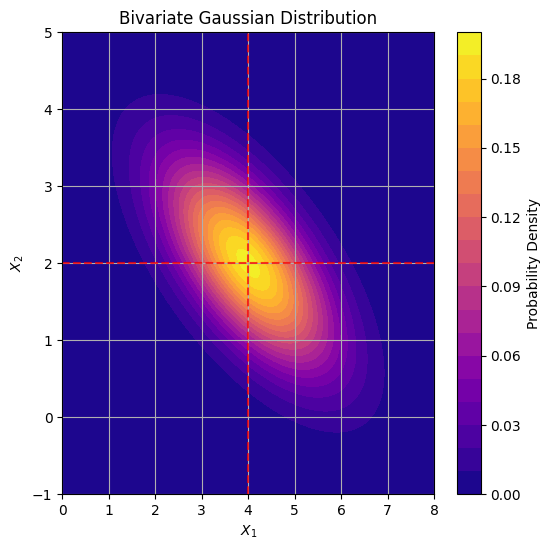

In [7]:
# Creating the grid to plot the bivariate gaussian
x1 = np.linspace(0, 8, 1000)
x2 = np.linspace(-1, 5, 1000)
X1, X2 = np.meshgrid(x1, x2)
pos = np.dstack((X1, X2))

# Computing the distribution
mvg=stat.multivariate_normal(mean=mu, cov=cov)
Z=mvg.pdf(pos)

# Plotting it and showing the position of the mean value
plt.figure(figsize=(6,6))
plt.contourf(X1, X2, Z, levels=20, cmap='plasma')
plt.colorbar(label='Probability Density')
plt.title('Bivariate Gaussian Distribution')
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.axhline(mu[1], color="red", linestyle="--", alpha=0.75)
plt.axvline(mu[0], color="red", linestyle="--", alpha=0.75)
plt.grid()
plt.show()

### 1. Plotting the Posterior Contours

First, we plot the contours of the posterior and indicate the 95% credible region.

- We define $\mu$ and $\Sigma$.
- We create a $1000 \times 1000$ grid over the parameter space with  
  $X_1 \in [0,\, 8]$ and $X_2 \in [-1,\, 5]$,  
  ensuring that important posterior contours lie well within the range.
- We stack the coordinates and evaluate the bivariate Gaussian PDF across the grid using `scipy.stats.multivariate_normal`.
- We then plot the posterior density using contour lines.
- The mean is indicated using two dashed red lines.

---

### 2. Marginalizing Over Parameters

Next, we marginalize over each parameter to obtain the 1D posterior distributions:

- To marginalize over $X_2$, integrate out $X_2$ from the joint distribution to get the marginal of $X_1$.
- To marginalize over $X_1$, integrate out $X_1$ to get the marginal of $X_2$.

Since the joint distribution is Gaussian, each marginal is a 1D Gaussian:

$$
X_1 \sim \mathcal{N}(4,\, 1.44), \quad X_2 \sim \mathcal{N}(2,\, 0.81)
$$

We compute the 95% credibility intervals for each marginal using:

```python
from scipy.stats import norm

mu1, sigma1 = 4, 1.2  # sqrt(1.44)
mu2, sigma2 = 2, 0.9  # sqrt(0.81)

cred_int_1 = norm.interval(0.95, loc=mu1, scale=sigma1)
cred_int_2 = norm.interval(0.95, loc=mu2, scale=sigma2)

In [8]:
# Marginalizing by integrating over each parameter
margx1=np.trapezoid(Z, x2, axis=1)
margx2=np.trapezoid(Z, x1, axis=0)

# Computing the Cumulative Distribution Function
cdf_x1=np.cumsum(margx1)*(x1[1]-x1[0])
cdf_x2=np.cumsum(margx2)*(x2[1]-x2[0])

# Finding the 95% credible intervals
lower_x1=x1[np.searchsorted(cdf_x1, 0.025)]
upper_x1=x1[np.searchsorted(cdf_x1, 0.975)]
lower_x2=x2[np.searchsorted(cdf_x2, 0.025)]
upper_x2=x2[np.searchsorted(cdf_x2, 0.975)]

print(f"95% Credibility Interval for X1: [{lower_x1:.3f}, {upper_x1:.3f}]")
print(f"95% Credibility Interval for X2: [{lower_x2:.3f}, {upper_x2:.3f}]")

# Finding the Credibility Intervals by fixing each parameter
sigma_1=np.sqrt(cov[0, 0])  
sigma_2=np.sqrt(cov[1, 1])  
rho=cov[0, 1]/(sigma_1*sigma_2)

x1_fixed=4
x2_fixed=2

# Computing the conditional mean and variance of Xi given Xj = xj_fixed i,j=1,2, i different from j
mu_2_given_1=mu[1]+rho*(sigma_2/sigma_1)*(x1_fixed-mu[0])
sigma_2_given_1=sigma_2*np.sqrt(1-rho**2)
mu_1_given_2=mu[0]+rho*(sigma_1/sigma_2)*(x2_fixed-mu[1])
sigma_1_given_2= sigma_1*np.sqrt(1-rho**2)

# Computing the 95% credibility interval
credibility_intervalx2=np.round(stat.norm.interval(0.95, loc=mu_2_given_1, scale=sigma_2_given_1), 3)
credibility_intervalx1=np.round(stat.norm.interval(0.95, loc=mu_1_given_2, scale=sigma_1_given_2), 3)

print(f"95% Credibility Interval for X2 given a fixed X1 = {x1_fixed}: {credibility_intervalx2}")
print(f"95% Credibility Interval for X1 given a fixed X2 = {x2_fixed}: {credibility_intervalx1}")

95% Credibility Interval for X1: [1.666, 6.374]
95% Credibility Interval for X2: [0.249, 3.781]
95% Credibility Interval for X2 given a fixed X1 = 4: [0.66 3.34]
95% Credibility Interval for X1 given a fixed X2 = 2: [2.213 5.787]


### 5. Monte Carlo Estimation: Cholesky Sampling

In this section, we use the **Cholesky decomposition** to generate Monte Carlo samples from the bivariate Gaussian posterior.

The main idea is as follows:

- We begin by decomposing the covariance matrix $\Sigma$ using the Cholesky factorization:
  $$
  \Sigma = L L^T
  $$
  This is implemented using the NumPy command `np.linalg.cholesky(cov)`.

- We then generate $10^5$ independent 2D standard normal samples, which are initially uncorrelated.

- To introduce the correct correlation structure, we transform these uncorrelated samples by multiplying them with the transpose of the Cholesky factor $L$, and then shifting by the mean $\mu$:
  $$
  \text{samples} = \mu + L^T \cdot \text{standard normal samples}
  $$

- This results in a cloud of samples that follow the intended correlated bivariate Gaussian distribution. When visualized, this distribution appears as a tilted ellipse, where the tilt and spread reflect the covariance structure.

- From the sampled data, we compute the **95% credibility intervals** by taking the 2.5th and 97.5th percentiles of the sample distribution for both parameters.

- Finally, we define a general-purpose plotting function that:
  - Draws the 2D posterior density using a contour plot,
  - Overlays the true posterior contours for reference,
  - Plots the marginal histograms of $X_1$ and $X_2$ with vertical lines showing the 95% intervals.

This function will also be reused for future sampling methods (Metropolis-Hastings and Gibbs).



95% Confidence Intervals obtained by Cholesky decomposition of the covariance matrix:
- for X1: [1.65, 6.36];
- for X2: [0.23, 3.76].


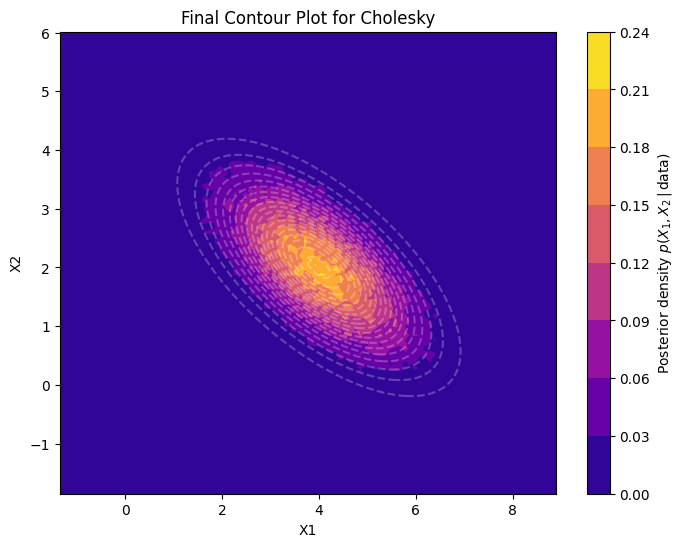

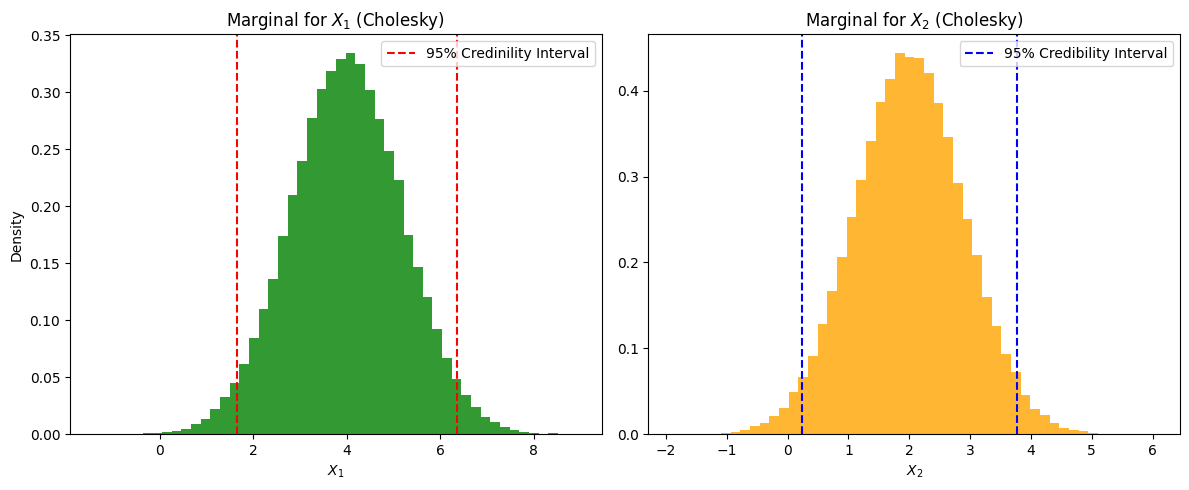

In [9]:
# a. Cholesky method
method="Cholesky"
L=np.linalg.cholesky(cov)
n_samples=100000
v=np.random.normal(size=(n_samples, 2))

# Transforming the samples using the Cholesky factor
samples_Cholesky=mu+v @ L.T

# Calculating the 95% confidence intervals
lower_bound=np.percentile(samples_Cholesky, 2.5, axis=0)
upper_bound=np.percentile(samples_Cholesky, 97.5, axis=0)

# Printing the confidence intervals
print(f"95% Confidence Intervals obtained by {method} decomposition of the covariance matrix:")
print(f"- for X1: [{lower_bound[0]:.2f}, {upper_bound[0]:.2f}];")
print(f"- for X2: [{lower_bound[1]:.2f}, {upper_bound[1]:.2f}].")

# Defining a function for the future plots
def f_contour_plot(samples, method, lower_bound, upper_bound):
    X1_samples=[x[0] for x in samples]
    X2_samples=[x[1] for x in samples]
    hist, x1edges, x2edges=np.histogram2d(X1_samples, X2_samples, bins=100, density=True)

    X1_S, X2_S=np.meshgrid((x1edges[:-1]+x1edges[1:])/2, (x2edges[:-1]+x2edges[1:])/2)


    # Plot using contourf
    plt.figure(1, figsize=(8, 6))
    plt.contourf(X1_S, X2_S, hist.T, cmap='plasma')
    plt.colorbar(label='Posterior density $p(X_1, X_2 \\,|\\,\\text{data})$')
    plt.contour(X1, X2, Z, levels=20, colors='white', linestyles='--', alpha=0.25)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(f"Final Contour Plot for {method}")
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram for X1
    axs[0].hist(X1_samples, bins=50, density=True, alpha=0.8, color='green')
    axs[0].axvline(lower_bound[0], linestyle='--', color='red', label='95% Credinility Interval')
    axs[0].axvline(upper_bound[0], linestyle='--', color='red')
    axs[0].set_title(f'Marginal for $X_1$ ({method})')
    axs[0].set_xlabel('$X_1$')
    axs[0].set_ylabel('Density')
    axs[0].legend()
    
    # Histogram for X2
    axs[1].hist(X2_samples, bins=50, density=True, alpha=0.8, color='orange')
    axs[1].axvline(lower_bound[1], linestyle='--', color='blue', label='95% Credibility Interval')
    axs[1].axvline(upper_bound[1], linestyle='--', color='blue')
    axs[1].set_title(f'Marginal for $X_2$ ({method})')
    axs[1].set_xlabel('$X_2$')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()


f_contour_plot(samples_Cholesky, method, lower_bound, upper_bound)

### 6. Monte Carlo Estimation: Metropolis-Hastings Sampling

The exercise now asks for the same procedure, but using the **Metropolis-Hastings (MH)** algorithm as the sampling method.

The Metropolis-Hastings algorithm is a **Markov Chain Monte Carlo (MCMC)** technique that constructs a sequence of samples by proposing new states and accepting or rejecting them based on their posterior probability.

The main steps are:

- **Initialization**: Choose a starting point (often the mean of the distribution).

- **Proposal step**: At each iteration, propose a new sample from a proposal distribution, usually a Gaussian centered at the current sample.

- **Acceptance step**: Accept the proposed sample with a probability proportional to the ratio of posterior probabilities (target distribution values) at the proposed and current states:
  $$
  \alpha = \min\left(1, \frac{p(\text{proposed})}{p(\text{current})}\right)
  $$
  If the proposed point is more probable, it is accepted; otherwise, it may still be accepted with some probability.

- Repeat for a large number of iterations to generate samples that follow the target distribution.

Key considerations:

- We need to carefully tune the **proposal distribution's standard deviation** to balance between high acceptance rate and efficient exploration.

- We will **discard initial samples as burn-in** to allow the chain to converge to the posterior.

- In addition to computing the **95% credibility intervals**, the exercise also requires plotting **traceplots** (parameter value vs. iteration index). These help assess how well the sampler explores the posterior and whether it mixes properly.

- As before, we will visualize:
  - The joint posterior using a contour plot,
  - Marginal histograms for $X_1$ and $X_2$,
  - And now, also the traceplots for both parameters.

This analysis helps verify that the Metropolis-Hastings sampler is correctly approximating the posterior distribution.


95% Confidence Intervals obtained by Metropolis-Hastings decomposition of the covariance matrix:
- for X1: [1.37, 6.05];
- for X2: [0.36, 3.87].


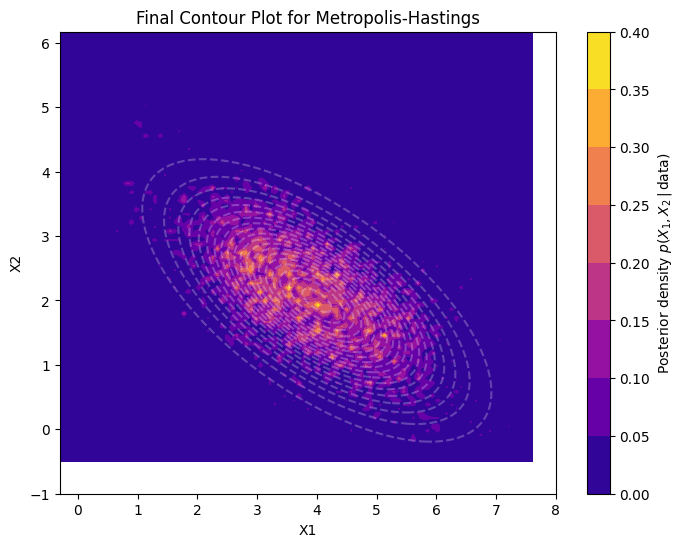

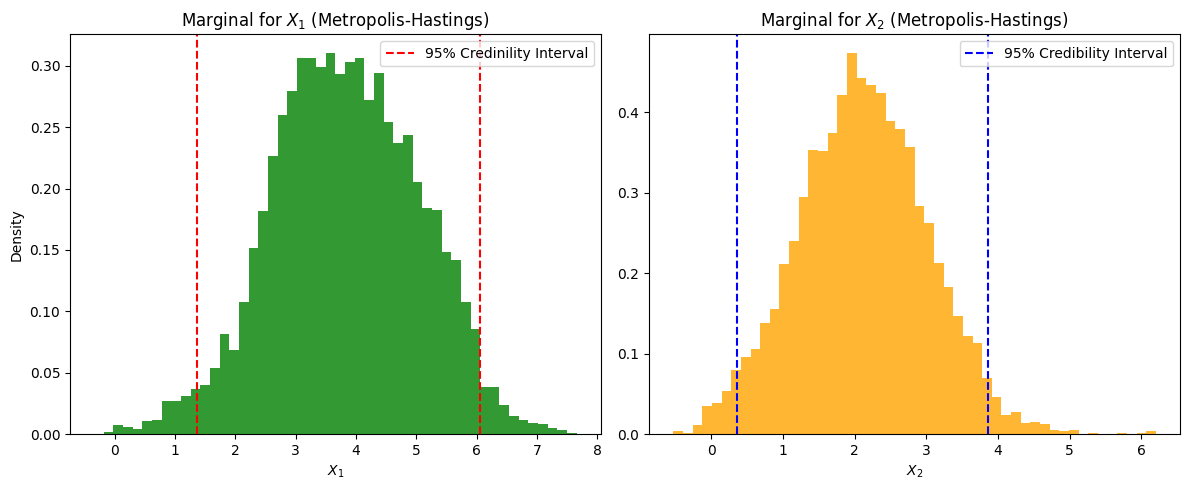

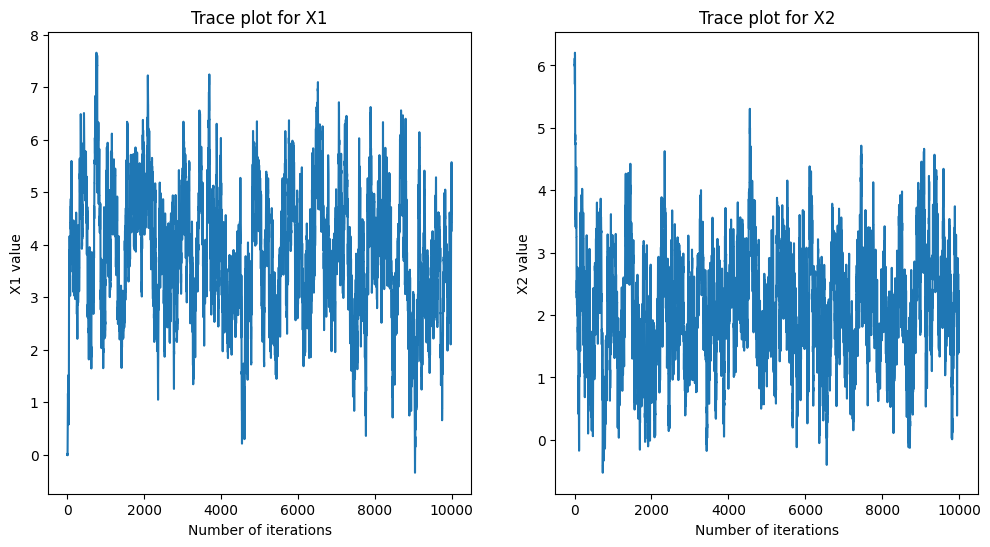

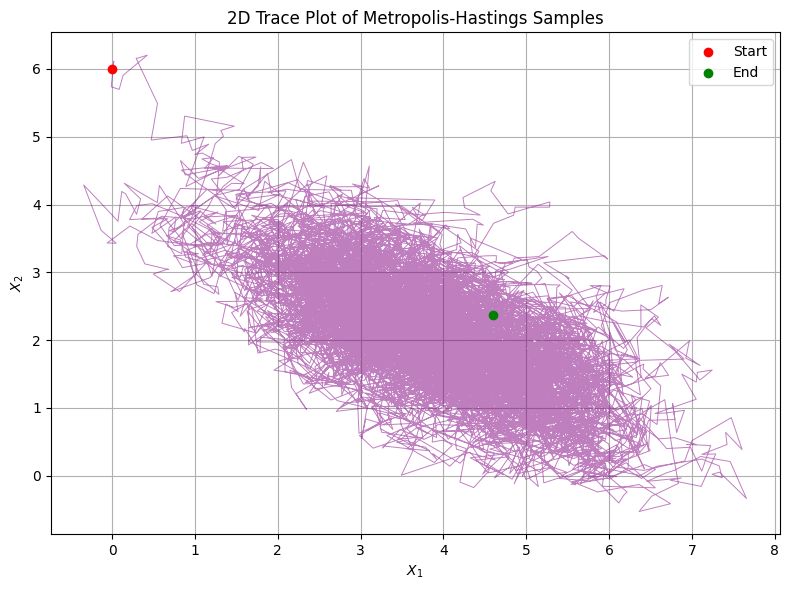

In [10]:
# b. Metropolis-Hastings
method='Metropolis-Hastings'

# Defining the algorithm
def bivariate_gaussian(x):
    return mvg.pdf(x)

def metropolis_hastings_bivariate(posterior, initial, proposal_std, iterations):

    current=np.array(initial)
    samples=[current]
    
    for _ in range(iterations):
        
        proposed=np.random.normal(current, proposal_std)
        
        acceptance_ratio=posterior(proposed)/posterior(current)
        acceptance_probability=min(1, acceptance_ratio)
        
        if np.random.rand() < acceptance_probability:
            current=proposed
       
        samples.append(current)
    
    return np.array(samples)

# Parameters
initial_guess = [0.0, 6.0]  
proposal_std = [0.3, 0.3]  
iterations = 10000 

# Metropolis-Hastings
samples_Metro_Hastings=metropolis_hastings_bivariate(bivariate_gaussian, initial_guess, proposal_std, iterations)

lower_bound=np.percentile(samples_Metro_Hastings, 2.5, axis=0)
upper_bound=np.percentile(samples_Metro_Hastings, 97.5, axis=0)

# Printing the confidence intervals
print(f"95% Confidence Intervals obtained by {method} decomposition of the covariance matrix:")
print(f"- for X1: [{lower_bound[0]:.2f}, {upper_bound[0]:.2f}];")
print(f"- for X2: [{lower_bound[1]:.2f}, {upper_bound[1]:.2f}].")

# Plotting the final contour, the marginalized posteriors and the trace plots
f_contour_plot(samples_Metro_Hastings, method, lower_bound, upper_bound)

MH_X1=samples_Metro_Hastings[:, 0]
MH_X2=samples_Metro_Hastings[:, 1]

fig, axs= plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(MH_X1)
axs[0].set_title('Trace plot for X1')
axs[0].set_xlabel('Number of iterations')
axs[0].set_ylabel('X1 value')
axs[1].plot(MH_X2)
axs[1].set_xlabel('Number of iterations')
axs[1].set_title('Trace plot for X2')
axs[1].set_ylabel('X2 value')
# Plot 2D trace
plt.figure(figsize=(8, 6))
plt.plot(MH_X1, MH_X2, color='purple', alpha=0.5, linewidth=0.7)
plt.scatter(MH_X1[0], MH_X2[0], color='red', label='Start', zorder=5)
plt.scatter(MH_X1[-1], MH_X2[-1], color='green', label='End', zorder=5)
plt.title('2D Trace Plot of Metropolis-Hastings Samples')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 7. Monte Carlo Estimation: Gibbs Sampling

Finally, we repeat the same procedure using **Gibbs sampling**.

Gibbs sampling is another **Markov Chain Monte Carlo (MCMC)** technique, but unlike Metropolis-Hastings, it samples each parameter **conditionally** on the current value of the other. This is particularly efficient for multivariate distributions where the **conditional distributions are known and easy to sample from** — which is the case for multivariate Gaussians.

The main idea is:

- Initialize the chain with some starting values for $X_1$ and $X_2$.

- Alternate between sampling from the conditional distributions:
  $$
  X_1^{(t+1)} \sim p(X_1 \mid X_2^{(t)}), \quad X_2^{(t+1)} \sim p(X_2 \mid X_1^{(t+1)})
  $$
  For a bivariate normal distribution, these conditional distributions are univariate normals and can be derived analytically.

- Repeat for a large number of iterations to generate samples that follow the target posterior.

As with Metropolis-Hastings:

- We discard an initial **burn-in period** to allow the sampler to converge.

- We compute the **95% credibility intervals** for both parameters from the resulting samples.

- We plot the **joint posterior contours**, **marginal histograms**, and **trace plots** for $X_1$ and $X_2$.

The trace plots are essential to verify **proper mixing and convergence** of the Gibbs sampler, and to ensure that it is adequately exploring the posterior distribution.

This method is often more efficient than Metropolis-Hastings when the conditional distributions are tractable and sampling is inexpensive.


95% Confidence Intervals obtained by Gibbs decomposition of the covariance matrix:
- for X1: [1.69, 6.34];
- for X2: [0.16, 3.75].


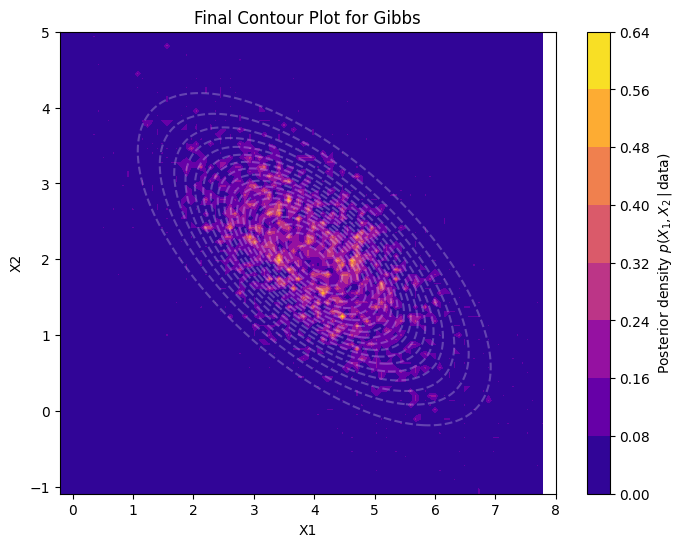

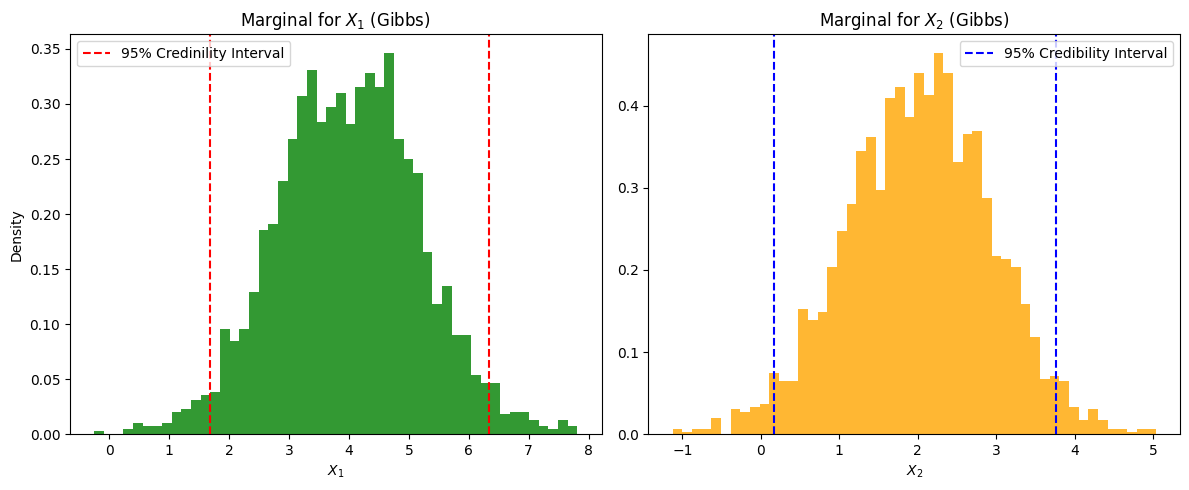

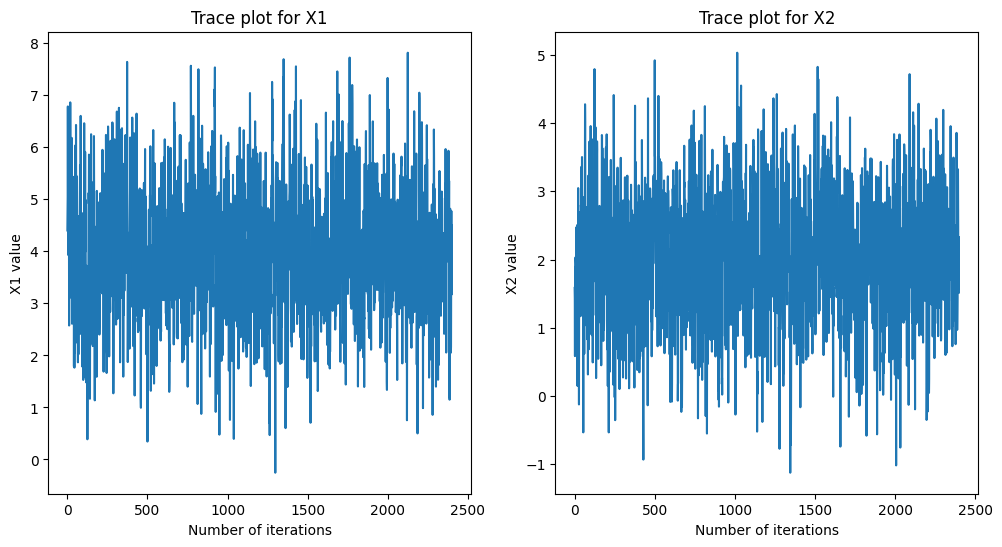

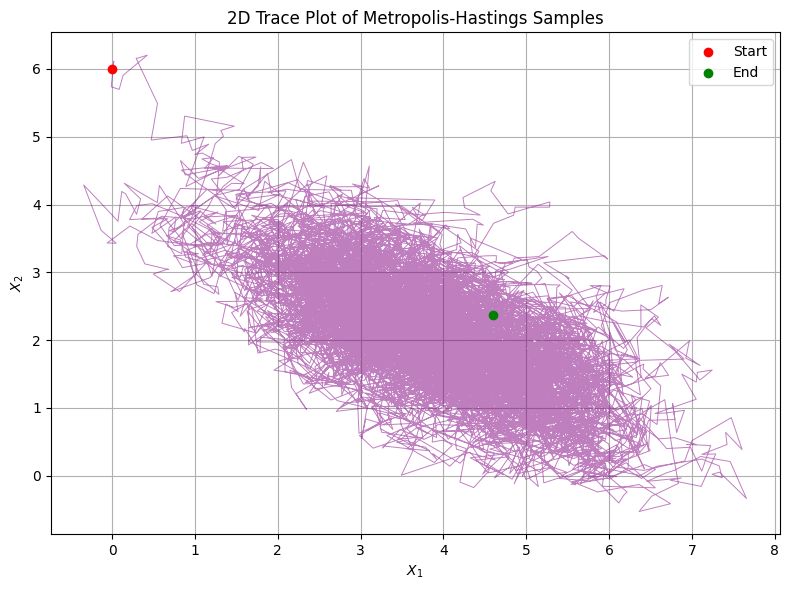

In [11]:
# c. Gibbs
method='Gibbs'

# Defining the algorithm
sigma_x1_given_x2=np.sqrt(cov[0, 0]-cov[0, 1]**2/cov[1, 1])
sigma_x2_given_x1=np.sqrt(cov[1, 1]-cov[1, 0]**2/cov[0, 0])

def gibbs_sampling(initial, iterations, burn_in):
    x1, x2=initial
    samples=[]

    for _ in range(iterations):
        
        mean_x1_given_x2=mu[0]+cov[0, 1]/cov[1, 1]*(x2-mu[1])
        x1=np.random.normal(mean_x1_given_x2, sigma_x1_given_x2)

        mean_x2_given_x1=mu[1]+cov[1, 0]/cov[0, 0]*(x1-mu[0])
        x2=np.random.normal(mean_x2_given_x1, sigma_x2_given_x1)

        samples.append([x1, x2])
    return np.array(samples[burn_in:])

# Parameters
initial_guess=[0.0, 0.0]
iterations=2500
burn_in=100

# Gibbs sampling
samples_Gibbs=gibbs_sampling(initial_guess, iterations, burn_in)

lower_bound=np.percentile(samples_Gibbs, 2.5, axis=0)
upper_bound=np.percentile(samples_Gibbs, 97.5, axis=0)

# Printing the confidence intervals
print(f"95% Confidence Intervals obtained by {method} decomposition of the covariance matrix:")
print(f"- for X1: [{lower_bound[0]:.2f}, {upper_bound[0]:.2f}];")
print(f"- for X2: [{lower_bound[1]:.2f}, {upper_bound[1]:.2f}].")

# Plotting the final contour, the marginalized posteriors and the trace plots
f_contour_plot(samples_Gibbs, method, lower_bound, upper_bound)

G_X1=samples_Gibbs[:, 0]
G_X2=samples_Gibbs[:, 1]

fig, axs=plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(G_X1)
axs[0].set_title('Trace plot for X1')
axs[0].set_xlabel('Number of iterations')
axs[0].set_ylabel('X1 value')
axs[1].plot(G_X2)
axs[1].set_xlabel('Number of iterations')
axs[1].set_title('Trace plot for X2')
axs[1].set_ylabel('X2 value')
# Plot 2D trace
plt.figure(figsize=(8, 6))
plt.plot(MH_X1, MH_X2, color='purple', alpha=0.5, linewidth=0.7)
plt.scatter(MH_X1[0], MH_X2[0], color='red', label='Start', zorder=5)
plt.scatter(MH_X1[-1], MH_X2[-1], color='green', label='End', zorder=5)
plt.title('2D Trace Plot of Metropolis-Hastings Samples')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()